# Active Learning Experiment Report

In dit verslag worden de resultaten gepresenteerd van een experimentele vergelijking tussen drie actieve leerstrategieën: **BatchBALD**, **BADGE** en **Random Sampling**. Het doel van dit experiment is om te analyseren welke strategie het meest efficiënt is in het verbeteren van modelprestaties met een beperkt aantal gelabelde voorbeelden.

De evaluatie is uitgevoerd op het **CIFAR-10** dataset, waarbij een **ResNet-18** model werd gebruikt. Per strategie zijn meerdere runs uitgevoerd, waarbij per iteratie het model opnieuw werd getraind met een uitgebreidere gelabelde subset.

---

## Overzicht van de strategieën

### Random Sampling
Bij elke iteratie worden willekeurig `n` datapunten geselecteerd uit de ongelabelde pool. Deze methode dient als referentiepunt om te beoordelen hoe goed de andere (informatieve) strategieën presteren.

### BADGE (Batch Active learning by Diverse Gradient Embeddings)
BADGE combineert informatierijke selectie met diversiteit. De methode maakt gebruik van de richting van de gradeint vector van de loss (zonder label) om informatieve voorbeelden te representeren, en gebruikt vervolgens **k-means++ clustering** om een diverse batch te selecteren.

Bron: Ash, J., & Adams, R. P. (2020). [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671)

### BatchBALD
BatchBALD is een Bayesiaanse benadering van active learning. Het kiest een batch van datapunten die gezamenlijk **de meeste mutual information** verschaffen over de modelparameters. In tegenstelling tot gewone BALD, kijkt deze methode naar de **gezamenlijke informatiewaarde van een batch**, in plaats van individuele onzekerheden.

Bron: Kirsch, A., van Amersfoort, J., & Gal, Y. (2019). [BatchBALD: Efficient and Diverse Batch Acquisition for Deep Bayesian Active Learning](https://arxiv.org/abs/1906.08158)

---

## Doel van het rapport

In dit rapport worden per strategie de volgende aspecten vergeleken:

-  **Test accuracy** over iteraties (gemiddelde + standaarddeviatie)
-  **Iteratietijd** en totale experimentele tijd
-  **Samenvattende tabel** met eindresultaten


Alle resultaten zijn verzameld via **MLflow** en opgeslagen in een **SQLite-database (`mlflow.db`)**, die in dit notebook wordt uitgelezen en geanalyseerd.

---

*Laatste bewerking: automatisch gegenereerd op basis van geregistreerde experimenten in MLflow.*


In [2]:
# Setup (via SQLite i.p.v. mlruns/ directory)
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

# Connect met mlflow.db
conn = sqlite3.connect("mlflow.db")

# Haal alle metric-entries met runinformatie op
runs_df = pd.read_sql('''
    SELECT r.run_uuid AS run_id, r.name as run_name, m.key, m.value, m.step
    FROM metrics m
    JOIN runs r ON m.run_uuid = r.run_uuid
''', conn)

# Pivot: metrics als kolommen
pivot_df = runs_df.pivot_table(index=["run_id", "run_name"], 
                                columns="key", 
                                values="value", 
                                aggfunc='max').reset_index()
pivot_df['strategy'] = pivot_df['run_name'].str.extract(r'^(.*)_resnet')
grouped = pivot_df.groupby('strategy')

In [3]:
valid_strategies = ["batchbald_mc", "badge", "random"]
runs_df = runs_df[runs_df['run_name'].str.extract(r'^(.*)_resnet')[0].isin(valid_strategies)]

## Groepeer runs per strategie

In [4]:
runs_df['strategy'] = runs_df['run_name'].str.extract(r'^(.*)_resnet')
grouped = runs_df.groupby('strategy')

## Test Accuracy per Iteratie

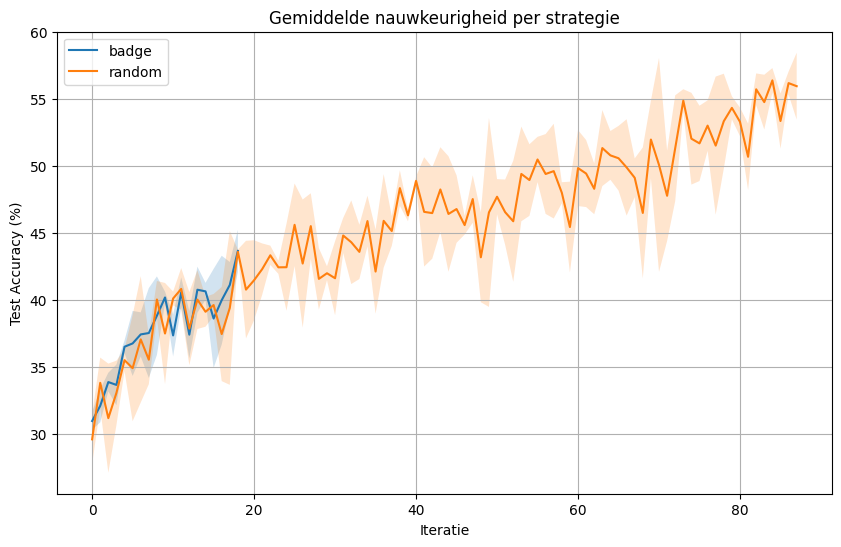

In [5]:
# Filter alleen accuracy-metrics (geen train_accuracy)
acc_df = runs_df[(runs_df['key'] == 'accuracy')]

plt.figure(figsize=(10, 6))

for strategy, group in acc_df.groupby(runs_df['strategy']):
    accs = []

    for run_id, run_group in group.groupby('run_id'):
        series = run_group.sort_values('step')['value'].reset_index(drop=True)
        accs.append(series)

    # Padding
    max_len = max(len(a) for a in accs)
    accs_padded = [a.tolist() + [None]*(max_len - len(a)) for a in accs]
    df = pd.DataFrame(accs_padded)

    plt.plot(df.mean(), label=strategy)
    plt.fill_between(df.columns, df.mean()-df.std(), df.mean()+df.std(), alpha=0.2)

plt.xlabel("Iteratie")
plt.ylabel("Test Accuracy (%)")
plt.title("Gemiddelde nauwkeurigheid per strategie")
plt.legend()
plt.grid()
plt.show()


## Iteratietijd per strategie

In [6]:
# Filter alleen iteratietijd metrics
it_df = runs_df[runs_df['key'].str.startswith('iteration_time')].copy()
it_df['iteration'] = it_df['key'].str.extract(r'iteration_time_(\d+)').astype(int)
it_df['strategy'] = it_df['run_name'].str.extract(r'^(.*)_resnet')

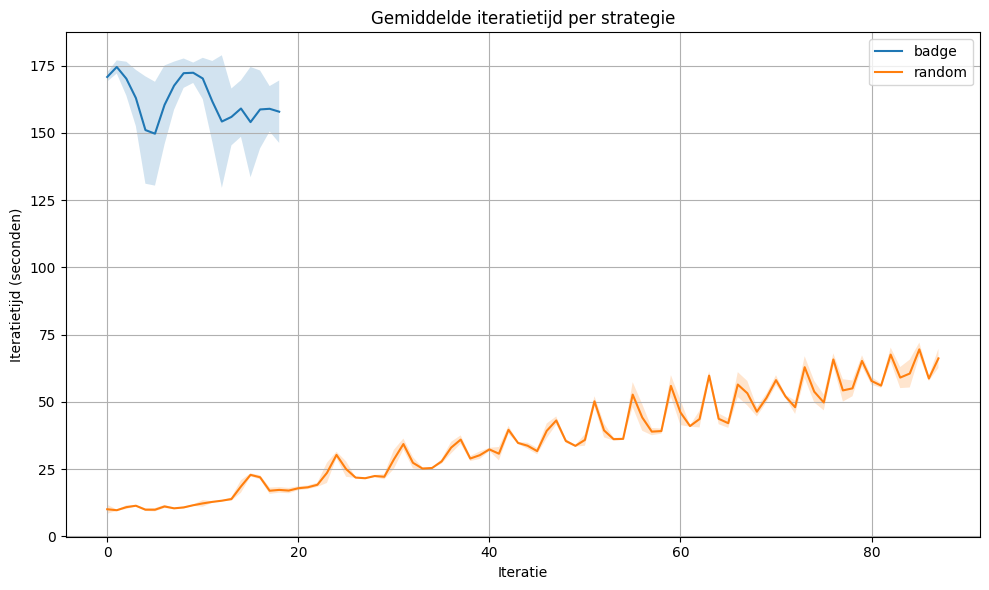

In [7]:
plt.figure(figsize=(10, 6))
for strategy, group in it_df.groupby('strategy'):
    grouped = group.groupby('iteration')['value']
    mean = grouped.mean()
    std = grouped.std()

    plt.plot(mean.index, mean.values, label=strategy)
    plt.fill_between(mean.index, mean - std, mean + std, alpha=0.2)

plt.xlabel("Iteratie")
plt.ylabel("Iteratietijd (seconden)")
plt.title("Gemiddelde iteratietijd per strategie")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Samenvattende Tabel

In [8]:
# === Instellingen ===
threshold = 70.0  # percentage accuracy
summary_keys = ["accuracy"] + [f"iteration_time_{i}" for i in range(100)]
summary_df = runs_df[runs_df["key"].isin(summary_keys)].copy()

# === Laatste accuracy per run ===
last_acc = summary_df[summary_df["key"] == "accuracy"].sort_values("step") \
            .groupby("run_id").tail(1)[["run_id", "value"]].rename(columns={"value": "accuracy"})

# === Gemiddelde iteratietijd per run ===
iter_times = summary_df[summary_df["key"].str.startswith("iteration_time")]
mean_iter_time = iter_times.groupby("run_id")["value"].mean().reset_index().rename(columns={"value": "avg_iter_time"})

# === Strategy aan runs koppelen ===
run_names = runs_df[["run_id", "run_name"]].drop_duplicates("run_id").copy()
run_names["strategy"] = run_names["run_name"].str.extract(r'^(.*)_resnet')

# === Merge: accuracy + tijd + strategy ===
merged = last_acc.merge(mean_iter_time, on="run_id", how="left")
merged = merged.merge(run_names[["run_id", "strategy"]], on="run_id", how="left")

# === Labels nodig voor threshold-accuracy ===
acc_df = runs_df[runs_df["key"] == "accuracy"].copy()
label_df = runs_df[runs_df["key"] == "label_count"].copy()
thresh_merged = pd.merge(acc_df, label_df, on=["run_id", "step"], suffixes=("_acc", "_labels"))
thresh_merged = thresh_merged.merge(run_names[["run_id", "strategy"]], on="run_id", how="left")

def first_threshold(group):
    met = group[group["value_acc"] >= threshold]
    if not met.empty:
        return met.sort_values("step").iloc[0]["value_labels"]
    else:
        return float("nan")

labels_needed = thresh_merged.groupby("run_id").apply(first_threshold).reset_index(name="labels_for_thresh")
labels_needed = labels_needed.merge(run_names[["run_id", "strategy"]], on="run_id", how="left")

# === Gemiddelde per strategie berekenen ===
final_df = merged.merge(labels_needed[["run_id", "labels_for_thresh"]], on="run_id", how="left")
summary = final_df.groupby("strategy").agg({
    "labels_for_thresh": ["mean", "std", "count"],
    "avg_iter_time": "mean"
}).dropna()

# === Mooi formatteren ===
summary.columns = ["labels_mean", "labels_std", "runs", "avg_iter_time"]
summary["labels_mean"] = summary["labels_mean"].astype(int)
summary["labels_std"] = summary["labels_std"].astype(int)
summary["avg_iter_time"] = pd.to_timedelta(summary["avg_iter_time"], unit="s").apply(
    lambda x: str(x).split(".")[0].replace("0 days ", "")
)

summary = summary.rename(columns={
    "labels_mean": f"Gem. labels voor {threshold:.0f}%",
    "labels_std": "Std",
    "runs": "Aantal runs",
    "avg_iter_time": "Gem. iteratietijd"
})

summary.style.format({
    f"Gem. labels voor {threshold:.0f}%": "{}",
    "Std": "{}",
    "Gem. iteratietijd": "{}"
})



/tmp/ipykernel_188257/3577525417.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  labels_needed = thresh_merged.groupby("run_id").apply(first_threshold).reset_index(name="labels_for_thresh")


,Gem. labels voor 70%,Std,Aantal runs,Gem. iteratietijd
strategy,,,,


In [9]:
# Export dit notebook naar PDF (voeg alleen uit in een .ipynb notebook)
!jupyter nbconvert --to pdf active_learning_report_sqlite.ipynb --output "active_learning_report.pdf"


[NbConvertApp] WARNING | pattern 'active_learning_report_sqlite.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=T